# 2) Logistic Regression
#### In this second notebook, we will explore the use of logistic models to mimic the behavior of the **Local Contrast** (*LC*) algorithm for image quality scoring, employed in astronomical image processing. The idea is to train the logistic model with subframes that have the lowest and the highest LC quality scores, respectively. Will the model then perform well at classifying any image as "high" or "low" quality? As in the first notebook, we will compare the model to the LC algorithm **quantitatively** and **qualitatively** (subjective aesthetic judgment).

We will move faster in this notebook, since the procedure will be similar to the previous one. 

In [2]:
import planet_utils as utils
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle

You must indicate here the path where you saved the Mars images dataset. (Large, 51206 images). The images are already quality-sorted by PIPP according to its LC quality algorithm (first images have highest quality).

In [3]:
folder_qualestimation = '/home/jorge/Desktop/mars_images/dataset/wholeset_qual/' # (This is my own folder path)

### Let us extract the data and quickly re-familiarize with it again

In [4]:
if not(os.path.isfile('whole_arr2d.npy') and os.path.isfile('whole_images_list.pickle')):
    whole_arr2d, _ , whole_images_list = utils.folder_to_data(folder_qualestimation)
    np.save('whole_arr2d', whole_arr2d) # (Note: this will save a large .npy file)
    with open('whole_images_list.pickle', 'wb') as file:
        pickle.dump(whole_images_list, file) # Save a pickle file
else:
    whole_arr2d = np.load('whole_arr2d.npy')
    with open('whole_images_list.pickle', 'rb') as file:
        whole_images_list = pickle.load(file)

In [4]:
# Paths to all subrames. Print the first few ones
whole_images_list[:3]

['/home/jorge/Desktop/mars_images/dataset/wholeset_qual/00000_2022-11-19-1852_7-T-RGB-Mars_f06353_quality_100%.png',
 '/home/jorge/Desktop/mars_images/dataset/wholeset_qual/00001_2022-11-19-1852_7-T-RGB-Mars_f03713_quality_99.89%.png',
 '/home/jorge/Desktop/mars_images/dataset/wholeset_qual/00002_2022-11-19-1852_7-T-RGB-Mars_f06987_quality_99.76%.png']

In [5]:
# Extract the PIPP quality scores (Local Contrast) from the file names, for later analysis
pipp_qual = utils.pipp_qual_parser(whole_images_list)

array([[<Axes: title={'center': 'pipp_quality_scores'}>]], dtype=object)

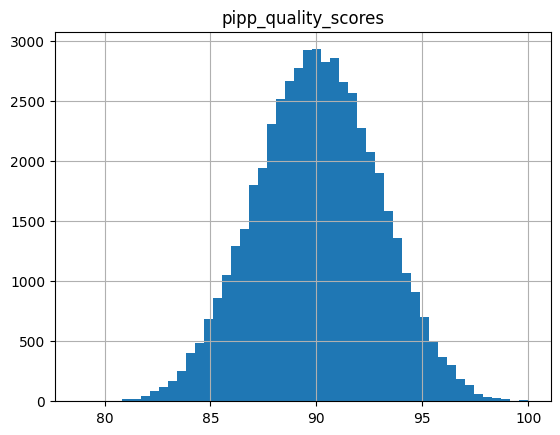

In [6]:
# Extract the PIPP quality scores (Local Contrast) from the file names, for later analysis
pipp_qual = utils.pipp_qual_parser(whole_images_list)
# Distribution of PIPP scores
pipp_df = pd.DataFrame({"pipp_quality_scores": pipp_qual})
pipp_df.hist("pipp_quality_scores", bins=50)

In [7]:
# Description of the image pixel data, from the 2D array (besides the array shape, we inspect only the first sample)
print(f'Shape: {whole_arr2d.shape}, Min: {np.min(whole_arr2d[0]):.{3}f}, Max: {np.max(whole_arr2d[0]):.{3}f}, Mean: {np.mean(whole_arr2d[0]):.{3}f}, SD: {np.std(whole_arr2d[0]):.{3}f}')

Shape: (51206, 49152), Min: 0.008, Max: 0.933, Mean: 0.209, SD: 0.247


Finally, let us display some of the highest and lowest rated subframes.

Best images vs. worst images: 


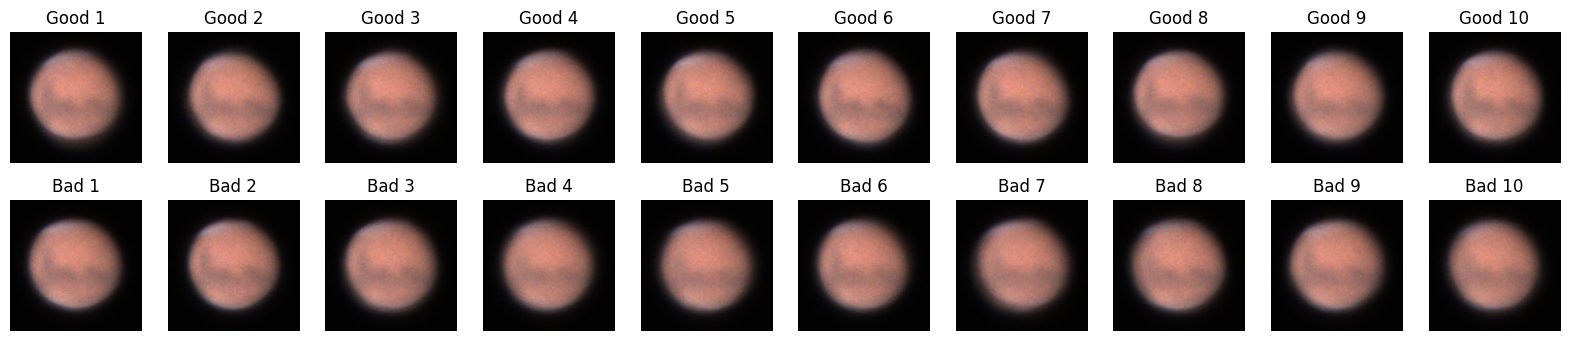

In [8]:
# Show the best and the worst 10
utils.show_best_worst(whole_images_list, show_paths=False)

### Specify training images

We make two classes of images:
- "good" (N best LC quality images)
- "bad" (N worst LC quality images)

In [9]:
N = 1000 # We might regard it as a "hyperparameter"

In [14]:
bad_imgs_arr = whole_arr2d[-N:] 
bad_imgs_paths = whole_images_list[-N:]
good_imgs_arr = whole_arr2d[:N] 
good_imgs_paths = whole_images_list[:N]
extremes_data = np.concatenate((bad_imgs_arr, good_imgs_arr), axis=0)
extremes_paths = bad_imgs_paths + good_imgs_paths

### Prepare subset

As in the previous notebook, let us work for now on a smaller images subset, which will speed up our exploration of the data.

In [12]:
len_subset = 4000

In [15]:
subset_paths = utils.random_selection(folder_qualestimation, len_subset) 
# Transform to 2D array
subset_arr2d = utils.paths_to_array(subset_paths)
# Get Y (PIPP score) for each image
pipp_score = utils.pipp_qual_parser(subset_paths)
# Create labels
extremes_labels = np.concatenate((np.zeros(len(bad_imgs_arr)), np.ones(len(good_imgs_arr))), axis=0)


num_samples:  4000
num_pixels:  49152
Shape:  (4000, 49152)


### Create and evaluate logistic model

In [21]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(extremes_data, extremes_labels, test_size=0.2, random_state=2)

In [22]:
# # Uncomment if we want to perform hyperparameter tuning. (Long computation).

# extremes_model = LogisticRegression(max_iter=2000)
# params_grid = {'C': [0.1, 1, 5, 10, 100]} 
# logistic_GS = GridSearchCV(extremes_model, param_grid=params_grid)
# logistic_GS.fit(x_train,y_train)
# print(logistic_GS.best_score_)
# print(logistic_GS.best_params_)
# extremes_model.fit(extremes_data, extremes_labels)
# print("Accuracy on test: ", extremes_model.score(x_test, y_test))
# pickle.dump(extremes_model, open("log_extremes.pickle", "wb")) # Save the model
# print("Logistic model saved")

In [23]:
# # Uncomment if we want to reuse a saved model

# extremes_model = pickle.load(open("log_extremes.pickle", "rb"))
# print("Accuracy on test: ", extremes_model.score(x_test, y_test))

In [24]:
# Comment out if we are loading a model in the cell above

# Train the model
c = 10 # I obtained on my own a 'C' (regularization hyperparameter) of 10.0
extremes_model = LogisticRegression(C=c, max_iter=2000)
extremes_model.fit(extremes_data, extremes_labels)
print("Accuracy on test: ", extremes_model.score(x_test, y_test))

Accuracy on test:  1.0


The accuracy was excellent. But we must remember that the logistic model was separating the very best images from the very worst ones, which makes it easier. 

Let us visualize how the logistic model separates the samples.

In [25]:
# PIPP scores in the subset
pipp_qual = utils.pipp_qual_parser(extremes_paths)
# The new probabilities (new quality estimation) according to the model
extremes_model_probs = extremes_model.predict_proba(extremes_data)
extremes_model_qual = list(extremes_model_probs[:,1])

In [28]:
extremes_data_df = pd.DataFrame({'pipp_quality': pipp_qual, 'logistic_qual': extremes_model_qual})

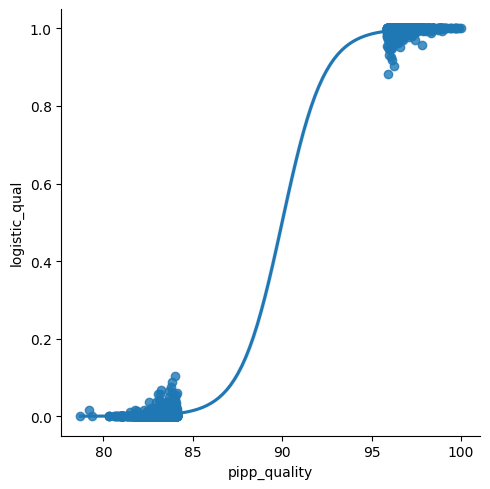

In [29]:
sns.lmplot(x='pipp_quality', y='logistic_qual', data=extremes_data_df, logistic=True)

The plot above also shows that the model seems to do quite well at separating the two classes ("low-" and "high-" quality images). How will it perform with images that are neither "too good" nor "too bad"?

### Evaluate the logistic model on a representative images subset

Let us take a random subset of pictures from the whole dataset.

In [31]:
len_subset = 2000
subset_paths = utils.random_selection(folder_qualestimation, len_subset) 
subset_arr2d = utils.paths_to_array(subset_paths)

num_samples:  2000
num_pixels:  49152
Shape:  (2000, 49152)


Apply the logistic model (trained with the best and the worst images) on the new subset and obtain quality measures:

In [34]:
subset_probs = extremes_model.predict_proba(subset_arr2d)
subset_extremesmodel_qual = list(subset_probs[:,1])
subset_pipp_qual = utils.pipp_qual_parser(subset_paths)

Prepare the data for a preliminary inspection.

In [37]:
subset_data_df = pd.DataFrame({'pipp_quality': subset_pipp_qual, 'model_quality': subset_extremesmodel_qual})

/home/jorge/Desktop/Code/planet_quality_ranking/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jorge/Desktop/Code/planet_quality_ranking/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


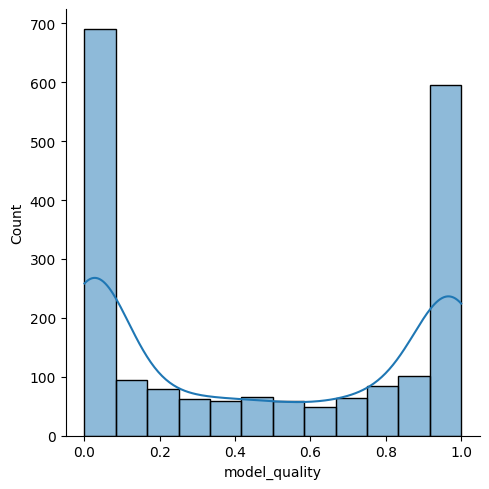

In [38]:
sns.displot(x='model_quality', data= subset_data_df, kde=True)

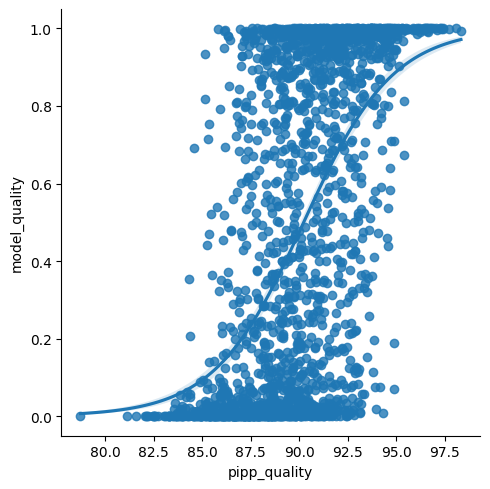

In [39]:
sns.lmplot(x='pipp_quality', y='model_quality', data=subset_data_df, logistic=True)

As we could expect, the logistic model tends to polarize the images into "good" ones or "bad" ones, since it was trained with the extremes of the quality values.

We are not really dealing with a classification problem, given that PIPP's LC quality algorithm returns quality estimation as a continuous variable, not as a categorical one. We might be able in some ways to transform the data and make it categorical, but for now we will just perform a Spearman's correlation to get an impression of how the two quality estimations relate to each other.

In [40]:
# Spearman's correlation
subset_data_df['pipp_quality'].corr(subset_data_df['model_quality'], method='spearman')

0.6152617065860047

We found an intermediate correlation, which gives us an indication that the model learned to predict the image quality values as the LC algorithm would, at least to some extent.

Let us now evaluate the two quality rankings subjectively.

In [41]:
# PIPP
pipp_subset_paths = sorted(subset_paths)
# Model
extremes_dict = {key: value for key, value in zip(subset_paths, subset_extremesmodel_qual)}
extremes_sorted_paths = sorted(extremes_dict.keys(), key=lambda x: extremes_dict[x], reverse=True)

PIPP  vs.  Model


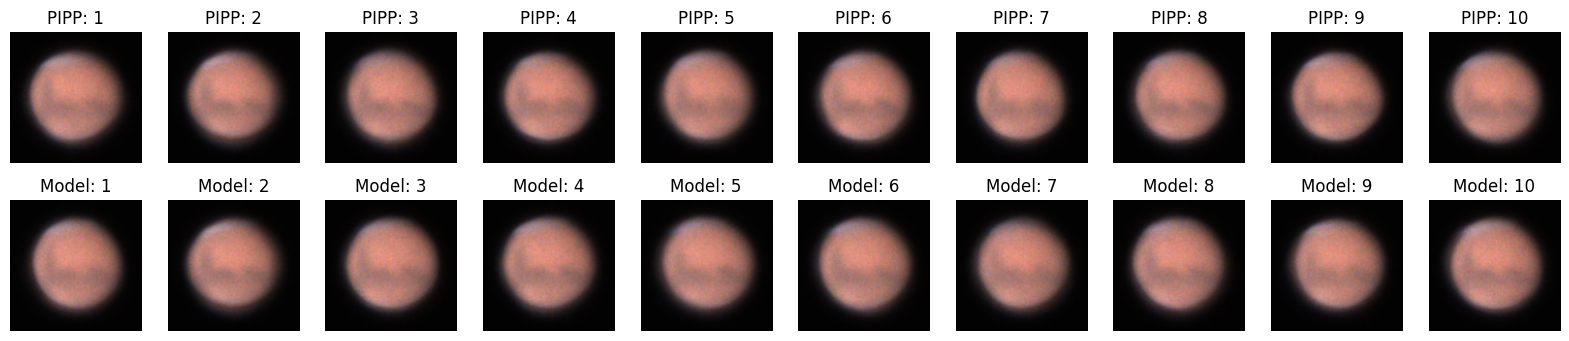

PIPP  vs.  Model


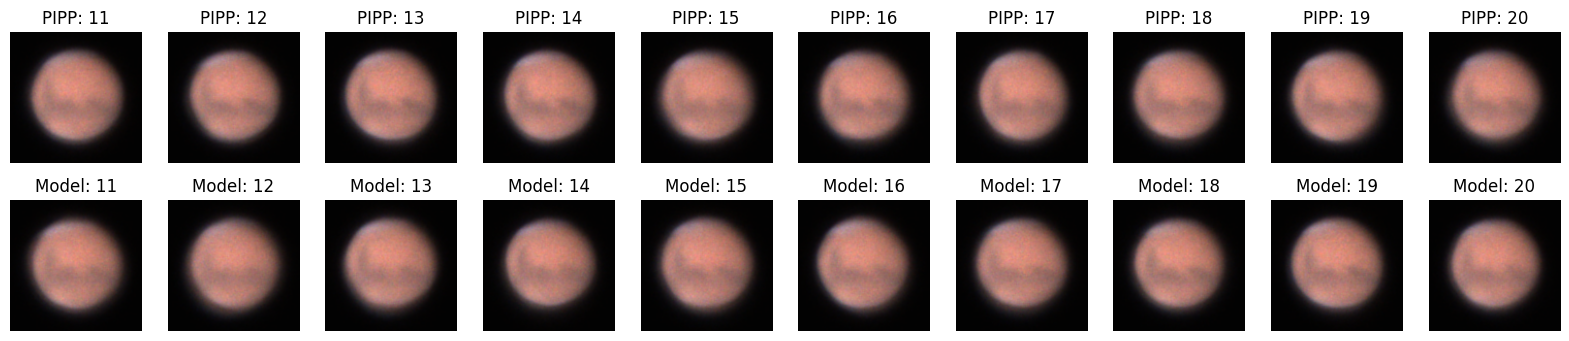

PIPP  vs.  Model


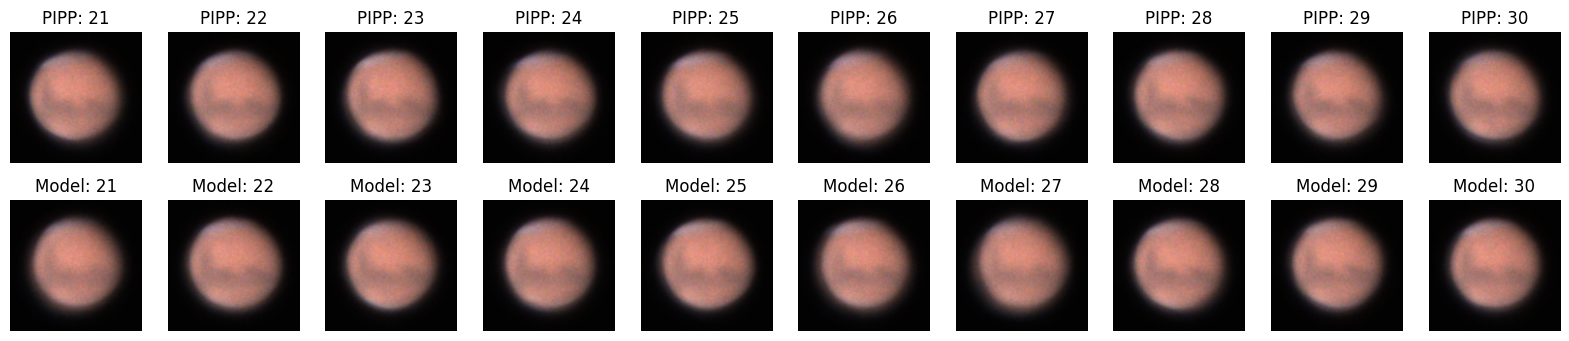

In [43]:
# When running this cell, press <Enter> to get a subsequent subset of 10 best quality images.
# Press <q>, followed by <Enter>, to stop the function. 
utils.images_compare(pipp_subset_paths, 'PIPP', extremes_sorted_paths, 'Model', 10)

This is only a casual evaluation, but I don't have the impression that the current approach might be more effective than PIPP's LC algorithm at sorting the images by quality. Although, of course, further tinkering might prove otherwise. In any case, when I tried with bigger subsets, the visual differences tended also to be similar. 

Since the subjective evaluation does not seem very promising, I will not further process any images.

### Conclusion

The logistic model was trained on very high and very low quality subframes, respectively. Therefore, it performed quite well at separating the "good" images from the "bad" ones. It also correlated moderately with images of a more representative sample, indicating a certain ability to predict image quality in the same way as PIPP's LC algorithm. However, to our disappointment, the logistic model did not seem to surpass the LC algorithm in terms of aesthetic quality ranking.  